In [4]:
import sys
sys.path.append('../')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tvgl_solver import *

# data
tickers = ['AAPL','GOOG','AMZN','INTC','BA','FDX']
start_date = '2010-08-01'
end_date = '2015-08-01'

data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']

# daily returns
returns = data.pct_change().dropna()

returns


Ticker,AAPL,AMZN,BA,FDX,GOOG,INTC
Date,,,,,,
2010-08-03 00:00:00+00:00,0.000306,0.019572,-0.002152,-0.011466,-0.001183,-0.013239
2010-08-04 00:00:00+00:00,0.004009,0.042150,0.001880,0.027861,0.033665,0.000869
2010-08-05 00:00:00+00:00,-0.004868,0.001960,-0.007797,-0.002443,0.003516,-0.002894
2010-08-06 00:00:00+00:00,-0.006152,0.003833,-0.000146,-0.005015,-0.015509,-0.000968
2010-08-09 00:00:00+00:00,0.006383,0.003974,0.004221,0.023089,0.010255,0.000000
...,...,...,...,...,...,...
2015-07-27 00:00:00+00:00,-0.013896,0.003759,-0.021033,0.003838,0.005934,0.010335
2015-07-28 00:00:00+00:00,0.004969,-0.010124,0.005531,0.028469,0.001180,0.021517
2015-07-29 00:00:00+00:00,-0.003161,0.005646,0.016430,0.014519,0.006258,0.001726


In [6]:
test_date=251
print(f"We will start the trading strategy from {returns.index[test_date]}")

We will start the trading strategy from 2011-08-01 00:00:00+00:00


In [7]:
def estimate_precision_inverse(data_window):
    cov_matrix = np.cov(data_window, rowvar=False)
    reg = 1e-4
    cov_matrix += reg * np.identity(cov_matrix.shape[0])
    precision_matrix = np.linalg.inv(cov_matrix)
    return precision_matrix

def split_the_data(data, freq, size):
    start = 0
    end = start + size
    data_splits = []
    while end <= len(data):
        split = data.iloc[start:end]
        data_splits.append(split)
        start += freq
        end = start + size
    return data_splits

def estimate_precision_tvgl(data_window, freq=25, size=25, lambda_=2.0, beta_=0.1):
    data_splits = split_the_data(data_window, freq, size)
    S = []
    n_list = []  

    for segment in data_splits:
        n_i = segment.shape[0]
        cov_i = np.cov(segment, rowvar=False)
        S.append(cov_i)
        n_list.append(n_i)
    
    T = len(S)
    p = data_window.shape[1]
    
    Thetas_estimated = solve_time_varying_graphical_lasso(
        S=S,
        n_list=n_list,
        lambda_=lambda_,
        beta=beta_,
        penalty_function=element_wise,
        p=p,
        T=T
    )
    precision_matrix = Thetas_estimated[-1]
    return precision_matrix


In [8]:
def min_var_portfolio_weights(precision_matrix):
    p = precision_matrix.shape[0]
    ones = np.ones((p, 1))
    numerator = precision_matrix @ ones
    denominator = (ones.T @ precision_matrix @ ones).item()
    weights = numerator / denominator
    return weights.flatten()

In [9]:
def trading_strategy(returns, test_date, method, window_size, step_size, lambda_=2.0, beta_=0.1):
    portfolio_returns = []
    dates = []
    
    for start in range(test_date, len(returns) - step_size, step_size):
        end = start
        if method == 'inverse':
            window = returns.iloc[end - window_size:end]
            precision = estimate_precision_inverse(window)
        elif method == 'tvgl':
            window = returns.iloc[end - window_size:end]
            precision = estimate_precision_tvgl(window, freq=25, size=25, lambda_=lambda_, beta_=beta_)
        else:
            raise ValueError("Unsupported method. Choose 'inverse' or 'tvgl'.")
        
        weights = min_var_portfolio_weights(precision)
        
        trade_start = end
        trade_end = end + step_size
        if trade_end > len(returns):
            trade_end = len(returns)
        
        trading_period = returns.iloc[trade_start:trade_end]
        
        # Calculate daily portfolio returns
        daily_portfolio_returns = trading_period @ weights
        
        # Compound the daily returns
        cumulative_return = (1 + daily_portfolio_returns).prod() - 1
        
        portfolio_returns.append(cumulative_return)
        dates.append(returns.index[trade_start])
    
    return pd.Series(portfolio_returns, index=dates)


In [10]:
step_size = 25

portfolio_inverse = trading_strategy(
    returns, 
    test_date=test_date, 
    method='inverse', 
    window_size=25, 
    step_size=step_size
)

portfolio_tvgl = trading_strategy(
    returns, 
    test_date=test_date, 
    method='tvgl', 
    window_size=125, 
    step_size=step_size, 
    lambda_=0.001, 
    beta_=0.2
)


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 25 03:45:02 AM: Your problem has 180 variables, 180 constraints, and 0 parameters.
(CVXPY) Jan 25 03:45:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 25 03:45:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 25 03:45:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 25 03:45:02 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 25 03:45:02 AM: Compiling problem (target solver=SCS).
(C

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   750| 1.16e-01  3.34e-02  1.14e+00 -4.21e+03  1.00e-01  9.59e-02 
  1000| 1.13e-01  3.04e-02  1.07e+00 -4.28e+03  1.00e-01  1.27e-01 
  1250| 1.10e-01  2.79e-02  1.01e+00 -4.35e+03  1.00e-01  1.58e-01 
  1500| 1.08e-01  2.58e-02  9.62e-01 -4.41e+03  1.00e-01  1.90e-01 
  1750| 1.30e-01  1.27e-02  3.70e-01 -4.49e+03  9.62e-03  2.37e-01 
  2000| 1.97e-01  9.85e-03  3.70e-01 -5.35e+03  9.62e-03  2.65e-01 
  2250| 1.52e-01  2.01e-03  2.72e-02 -5.34e+03  9.62e-03  2.91e-01 
  2500| 1.09e-01  1.95e-03  2.85e-02 -5.34e+03  9.62e-03  3.18e-01 
  2750| 9.06e-02  1.65e-03  2.93e-02 -5.34e+03  9.62e-03  3.44e-01 
  3000| 8.07e-02  1.65e-03  2.98e-02 -5.35e+03  9.62e-03  3.70e-01 
  3250| 7.26e-02  1.64e-03  3.00e-02 -5.35e+03  9.62e-03  3.96e-01 
  3500| 6.61e-02  1.60e-03  3.01e-02 -5.35e+03  9.62e-03  4.23e-01 
  3750| 6.08e-02  1.58e-03  3.00e-02 -5.35e+03  9.62e-03  4.49e-01 
  4000| 5.65e-02  1.55e-03  3.00e-02 -5.36e+03  9.62e-03  4.76e-01 
  4250| 4.15e+01  5.90e-01  2.11e-02 -5.41e+03  

 window_size=125, 
    step_size=step_size, 
    lambda_=0.01, 
    beta_=0.2

In [11]:
def calculate_performance(portfolio):
    # Correct cumulative return by compounding
    cumulative_return = (1 + portfolio).prod() - 1
    
    # Sharpe Ratio assuming step_size periods per year
    sharpe_ratio = (portfolio.mean() / portfolio.std()) * np.sqrt(252 / step_size)
    
    # Calculate running maximum for drawdown
    cumulative = (1 + portfolio).cumprod()
    running_max = cumulative.cummax()
    drawdown = running_max - cumulative
    max_drawdown = drawdown.max()
    
    return cumulative_return, sharpe_ratio, max_drawdown


In [12]:
c_return_inv, sharpe_inv, drawdown_inv = calculate_performance(portfolio_inverse)
c_return_tvgl, sharpe_tvgl, drawdown_tvgl = calculate_performance(portfolio_tvgl)

metrics_df = pd.DataFrame({
    'Method': ['Inverse Covariance', 'TVGL'],
    'Cumulative Return': [c_return_inv, c_return_tvgl],
    'Sharpe Ratio': [sharpe_inv, sharpe_tvgl],
    'Maximum Drawdown': [drawdown_inv, drawdown_tvgl]
})

metrics_df

,Method,Cumulative Return,Sharpe Ratio,Maximum Drawdown
0,Inverse Covariance,1.429987,1.703372,0.080481
1,TVGL,1.737669,1.878408,0.098915


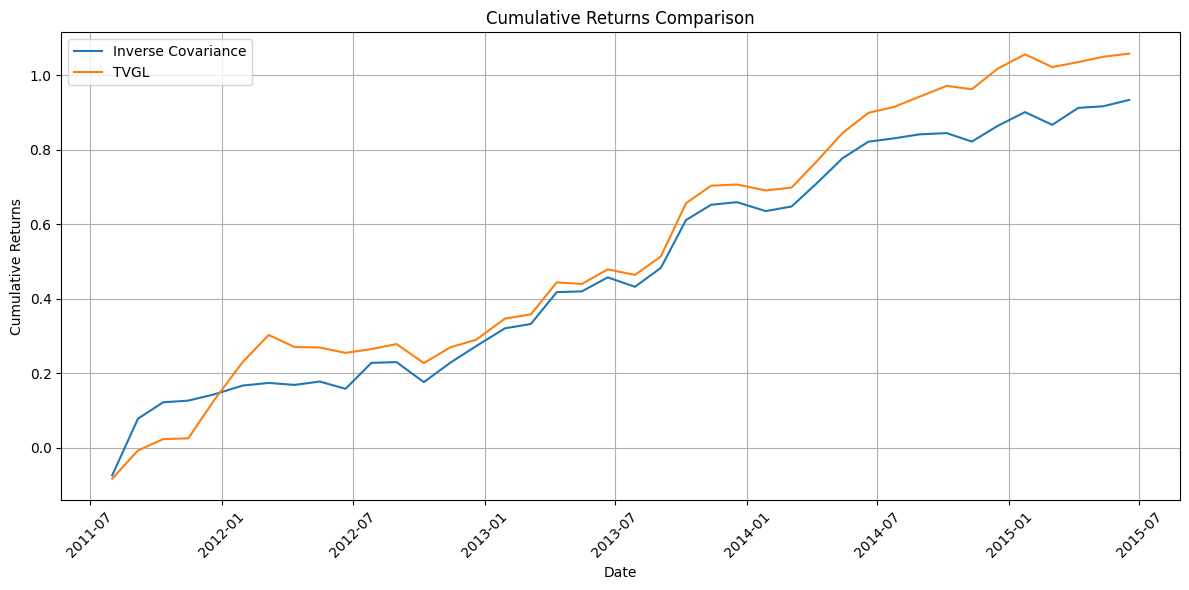

In [15]:
cumulative_inverse = portfolio_inverse.cumsum()
cumulative_tvgl = portfolio_tvgl.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_inverse, label='Inverse Covariance')
plt.plot(cumulative_tvgl, label='TVGL')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
